In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%config InlineBackend.figure_format = 'retina'


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Graph Optimisation by Networkx

**Solving Chinese Postman Problem in Python**
1. Motivating Graph Optimisation
2. Graph Representation and Networkx
3. Load Data and Create Graph
4. EDA on Graph
5. Solving CPP
    - CPP Algorithm
    - Premises
    - Step 1: Find Nodes of Odd Degree
    - Step 2: Find Min Distance Pairs
    - Step 3: Compute Eulerian Circuit
    - Compute CPP and Visualise

### Motivating Graph Optimisation
> TSP finds the shortest route traversing a subset of all nodes whereas CPP finds the shortest route traversing ALL nodes by retracting at least once.

### Graph
> `node == vertex == point`
> `edge == arc == link`
- **Direction** (undirected vs directed)
- **Weight** (edge-weighted accounts for distance between pairs of adjacent nodes, i.e. edge attribute = "distance")
- **Degree** (number of edges linking a node)
- **Eulerian tour**: a graph where a full-cycle passing through all edges exactly once made from starting node back to itself (aka Eulerian circuit, Eulerian cycle)
- **Match** (a subset of edge having unique node traverse (e.g. 'minimum weight matching' finds the matching with lowest possible total edge weight)

In [2]:
import itertools
import copy
import networkx as nx

### Load Data
**Edge List**
> Edge list is a simple data structure containing data representing the graph
- node1 & node2 : names of node-pairs
- trail : edge-attr abbreviation
- distance : edge-attr showing length in miles
- color : trail color used for plotting
- estimate : edge-attr showing reference to trailmap as binary, not used for analysis

In [3]:
# Download EdgeList from cloud
edgelist = pd.read_csv('https://gist.githubusercontent.com/brooksandrew/e570c38bcc72a8d102422f2af836513b/raw/89c76b2563dbc0e88384719a35cba0dfc04cd522/edgelist_sleeping_giant.csv')

edgelist.head(10)

,node1,node2,trail,distance,color,estimate
0,rs_end_north,v_rs,rs,0.30,red,0
1,v_rs,b_rs,rs,0.21,red,0
2,b_rs,g_rs,rs,0.11,red,0
3,g_rs,w_rs,rs,0.18,red,0
4,w_rs,o_rs,rs,0.21,red,0
5,o_rs,y_rs,rs,0.12,red,0
6,y_rs,rs_end_south,rs,0.39,red,0
7,rc_end_north,v_rc,rc,0.70,red,0
8,v_rc,b_rc,rc,0.04,red,0
9,b_rc,g_rc,rc,0.15,red,0


**Node List**
> Often optional data in graphical optimisation in Networkx where EdgeList containing node info; here used for adding node-attr:
- id : name of node in pairs
- X : H-coordinate relative to topleft
- Y : V-coordinate relative to topleft

**Note on Generating Node/Edge lists
Manual effort exerted where possible node named by trail1_trail2 alphabetically; more complex when the same trails cross each other more than once

In [4]:
# Preview NodeList

nodelist = pd.read_csv('https://gist.githubusercontent.com/brooksandrew/f989e10af17fb4c85b11409fea47895b/raw/a3a8da0fa5b094f1ca9d82e1642b384889ae16e8/nodelist_sleeping_giant.csv')

nodelist.head(5)

,id,X,Y
0,b_bv,1486,732
1,b_bw,716,1357
2,b_end_east,3164,1111
3,b_end_west,141,1938
4,b_g,1725,771


### Create Graph and Inspection

In [35]:
g = nx.Graph()

# Add edges and edge-attr
for i, row in edgelist.iterrows():
    # NOTE how to add edge with dict(attr)
    # ( [ (edge1, edge2, dict()), (another if need) ] )
    g.add_edges_from(
        [(row[0], row[1], dict(row[2:]))]
    )
    
# Check EdgeList examples
print(row[0]) # node1
print(row[1]) # node2
print(row[2:].to_dict()) # edge-attr dict

o_gy2
y_gy2
{'trail': 'gy2', 'distance': 0.12, 'color': 'yellowgreen', 'estimate': 0}


In [42]:
# Add node-attr
for i, nrow in nodelist.iterrows():
    g.add_nodes_from(
        [(nrow['id'], dict(nrow[1:]))]
        )

print(nrow)

id    y_rt
X      977
Y     1666
Name: 76, dtype: object


In [43]:
# Edges as ListofTuples
    # list() needed for slicing
list(g.edges(data=True))[:5]

[('rs_end_north',
  'v_rs',
  {'trail': 'rs', 'distance': 0.3, 'color': 'red', 'estimate': 0}),
 ('v_rs',
  'b_rs',
  {'trail': 'rs', 'distance': 0.21, 'color': 'red', 'estimate': 0}),
 ('v_rs',
  'v_bv',
  {'trail': 'v', 'distance': 0.52, 'color': 'violet', 'estimate': 0}),
 ('v_rs',
  'v_end_east',
  {'trail': 'v', 'distance': 0.54, 'color': 'violet', 'estimate': 0}),
 ('b_rs',
  'g_rs',
  {'trail': 'rs', 'distance': 0.11, 'color': 'red', 'estimate': 0})]

In [44]:
# Similar for nodes
list(g.nodes(data=True))[:10]

[('rs_end_north', {'X': 1772, 'Y': 172}),
 ('v_rs', {'X': 1793, 'Y': 484}),
 ('b_rs', {'X': 1747, 'Y': 700}),
 ('g_rs', {'X': 1676, 'Y': 775}),
 ('w_rs', {'X': 1646, 'Y': 947}),
 ('o_rs', {'X': 1724, 'Y': 1148}),
 ('y_rs', {'X': 1805, 'Y': 1246}),
 ('rs_end_south', {'X': 1865, 'Y': 1598}),
 ('rc_end_north', {'X': 867, 'Y': 618}),
 ('v_rc', {'X': 1288, 'Y': 934})]

In [46]:
# Summary Stats

print(f'# of edges: {g.number_of_edges()}')
print(f'# of nodes: {g.number_of_nodes()}')

# of edges: 123
# of nodes: 77


## Visualise Graph
> Manipulating Colours and Layout

- Positions: node positions from graph as dict, allowing to recreate graph using the same layout as the actual trail map. Y is negated to transform Y-axis origin from topleft to bottomleft
- Colour: edge colours as list to visualise trails colourfully

In [47]:
# Define node positions as dict for plotting
    # so... comprehension can be used with dict too? what about tuple? - so tuple-COMP is a generator
node_positions = {node[0]: (node[1]['X'], -node[1]['Y']) for node in g.nodes(data=True)}

# Checking it with a bit of hack (note no head/slice method for dict)
dict(list(node_positions.items())[:5])

{'rs_end_north': (1772, -172),
 'v_rs': (1793, -484),
 'b_rs': (1747, -700),
 'g_rs': (1676, -775),
 'w_rs': (1646, -947)}

In [52]:
# Define list of edge colours for plotting
edge_colours = [e[2]['color'] for e in g.edges(data=True)]

edge_colours[:10]

['red',
 'red',
 'violet',
 'violet',
 'red',
 'blue',
 'blue',
 'red',
 'green',
 'green']

<Figure size 576x432 with 0 Axes>

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Text(0.5, 1.0, 'Graph of Sleeping Giant Trail')

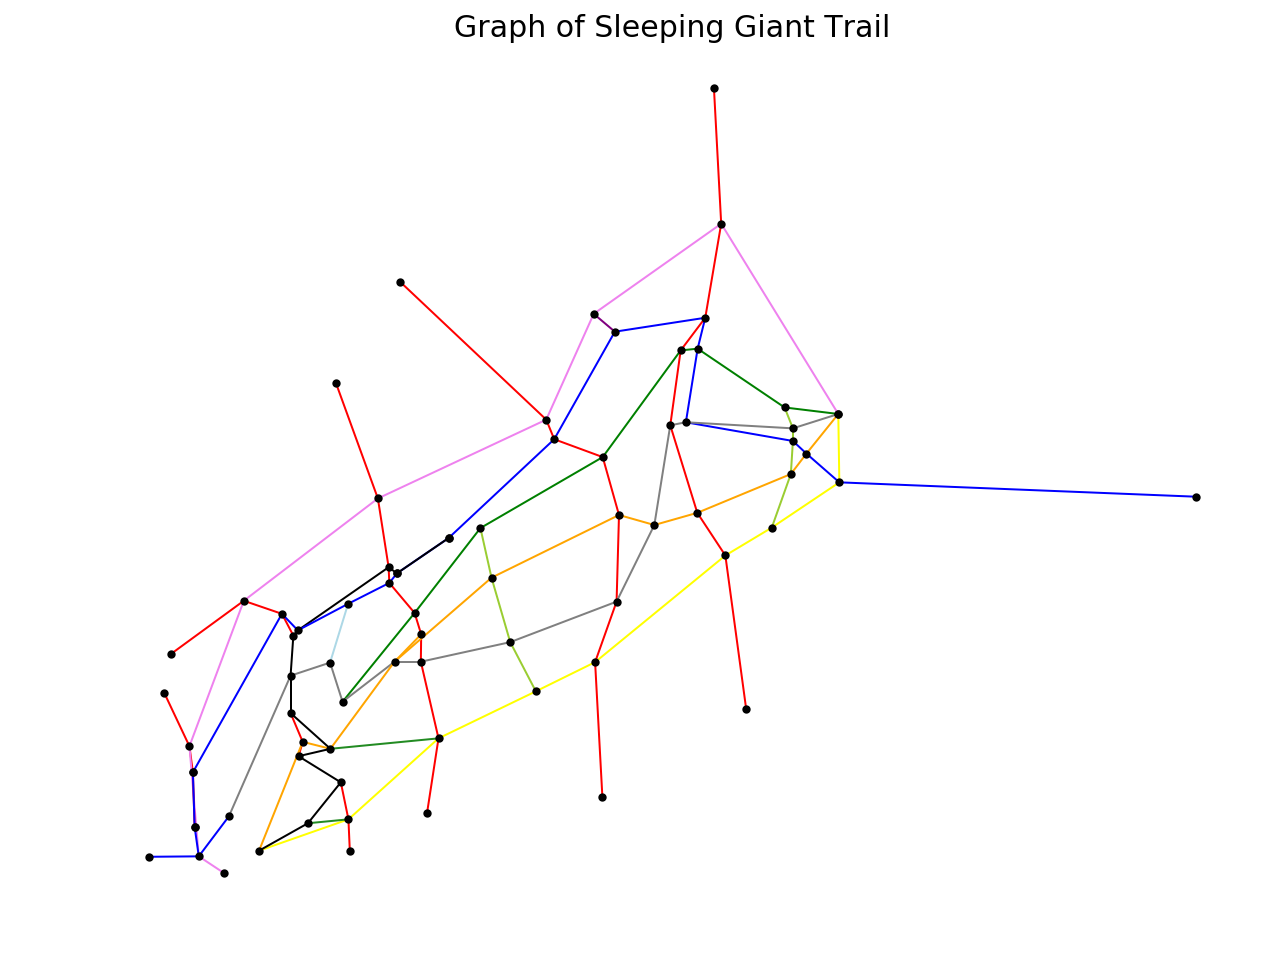

In [53]:
plt.figure(figsize=(8, 6))
nx.draw(g, pos=node_positions, edge_color=edge_colours, node_size=10, node_color='black')
plt.title('Graph of Sleeping Giant Trail', size=15)
plt.show()

### Overview of CPP Algorithm
1. Find all nodes with odd degree (find all trail crosses where the number of trails touching that cross is odd number)
2. Add edges to graph such that all nodes of odd degree are made even. Added edges must be duplicates from original graph. Set of edges added should sum to minimum distance possible (NP-Hard problem) (autrement dit, minimise the amount of retracting on a route hitting all trails)
3. Given a starting point, find the Eulerian tour over the augmented dataset (once knowing which trails to retract and compute route from start to end)

### Premises
While a shorter and more precise path could be generated by relaxing the assumptions below, this would add complexity beyond the scope of this setup, which focuses on the CPP.
#### Premise 1: Required trails only
Boundary route could be used to connect trails, but ignore optional trails.
#### Premise 2: Uphill == downhill
CPP assumes equal cost as distance, direction-less travel. But here some trails are in fact harder as uphill. Incorporating distance and elevation over directed graph as Windy Postman Problem
#### Premise 3: No parallel edges (trails)
Parallel edges add complexity to the problem and requires robust solution. (see [package](https://github.com/brooksandrew/postman_problems))

In [59]:
# Step 1: Find nodes of odd degree
nodes_odd_degree = [v for v, d in g.degree if d % 2 == 1]

nodes_odd_degree[:5]

['rs_end_north',
 'rs_end_south',
 'rc_end_north',
 'rc_end_south',
 'rt_end_north']

In [60]:
# Counts
print(f'# nodes of odd degree: {len(nodes_odd_degree)}')
print(f'# total nodes: {len(g.nodes())}')

# nodes of odd degree: 36
# total nodes: 77


In [62]:
# Step 2: Find Min Distance Pairs

# (1) Compute All Pairs of odd nodes as ListofTuples
odd_node_pairs = list(itertools.combinations(nodes_odd_degree, 2))

odd_node_pairs[:10]

[('rs_end_north', 'rs_end_south'),
 ('rs_end_north', 'rc_end_north'),
 ('rs_end_north', 'rc_end_south'),
 ('rs_end_north', 'rt_end_north'),
 ('rs_end_north', 'o_rt'),
 ('rs_end_north', 'y_rt'),
 ('rs_end_north', 'rt_end_south'),
 ('rs_end_north', 'rh_end_north'),
 ('rs_end_north', 'rh_end_tt_1'),
 ('rs_end_north', 'rh_end_tt_2')]

In [63]:
# Counts
print(f'# pairs: {len(odd_node_pairs)}')

# pairs: 630


Confirming this with combinatoric, with ease as number is small
$$\begin{equation*} \#\;of\;pairs = n\;choose\;r = {n \choose r} = \frac{n!}{r!(n-r)!} = \frac{36!}{2! (36-2)!} = 630 \end{equation*} $$

In [64]:
# (2) Compute Shortest Paths between Node Pairs
# networkx has easy method of Dijkstra's algorithm for this

def get_shortest_paths_distances(graph, pairs, edge_weight_name):
    """Compute SD between pairs"""
    distances = {}
    for pair in pairs:
        distances[pair] = nx.dijkstra_path_length(graph, pair[0], pair[1], weight=edge_weight_name)
    return distances

odd_node_pairs_shortest_paths = get_shortest_paths_distances(g, odd_node_pairs, 'distance')

dict(list(odd_node_pairs_shortest_paths.items())[:10])

{('rs_end_north', 'rs_end_south'): 1.52,
 ('rs_end_north', 'rc_end_north'): 1.79,
 ('rs_end_north', 'rc_end_south'): 1.79,
 ('rs_end_north', 'rt_end_north'): 1.8900000000000001,
 ('rs_end_north', 'o_rt'): 1.75,
 ('rs_end_north', 'y_rt'): 1.9200000000000002,
 ('rs_end_north', 'rt_end_south'): 2.1,
 ('rs_end_north', 'rh_end_north'): 2.2700000000000005,
 ('rs_end_north', 'rh_end_tt_1'): 2.06,
 ('rs_end_north', 'rh_end_tt_2'): 2.2}

In [68]:
# (3) Create Complete Graph linking all node-pair in (1) with shortest path distance attr from (2)

def create_complete_graph(pair_weights, flip_weights=True):
    """
    Create a clique using list of vertex pairs and SP
    Params:
        pair_weights: list[tuple] from output of (3)
        flip_weights: boolean, should negate edge attr in pari_weights?
    """
    g = nx.Graph()
    for k, v in pair_weights.items():
        wt_i = -v if flip_weights else v
        g.add_edges_from([(k[0], k[1], {'distance':v, 'weight':wt_i})])
    return g

# Generate the clique graph
g_odd_clique = create_complete_graph(odd_node_pairs_shortest_paths, flip_weights=True)

# Counts
print(f'# nodes: {len(g_odd_clique.nodes())}')
print(f'# edges: {len(g_odd_clique.edges())}')


# nodes: 36
# edges: 630


**Complete Graph** is a clique, here an example of clique (7-node, 21-edge (7 choose 2))
![Clique](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1508151819/148px-Complete_graph_K7_q8zuli.png)

<Figure size 576x432 with 0 Axes>

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


(-10.155510024138124,
 3315.1555100241385,
 -2066.20754131339,
 -81.79245868661008)

Text(0.5, 1.0, 'Complete Graph (Clique) of Odd-degree Nodes')

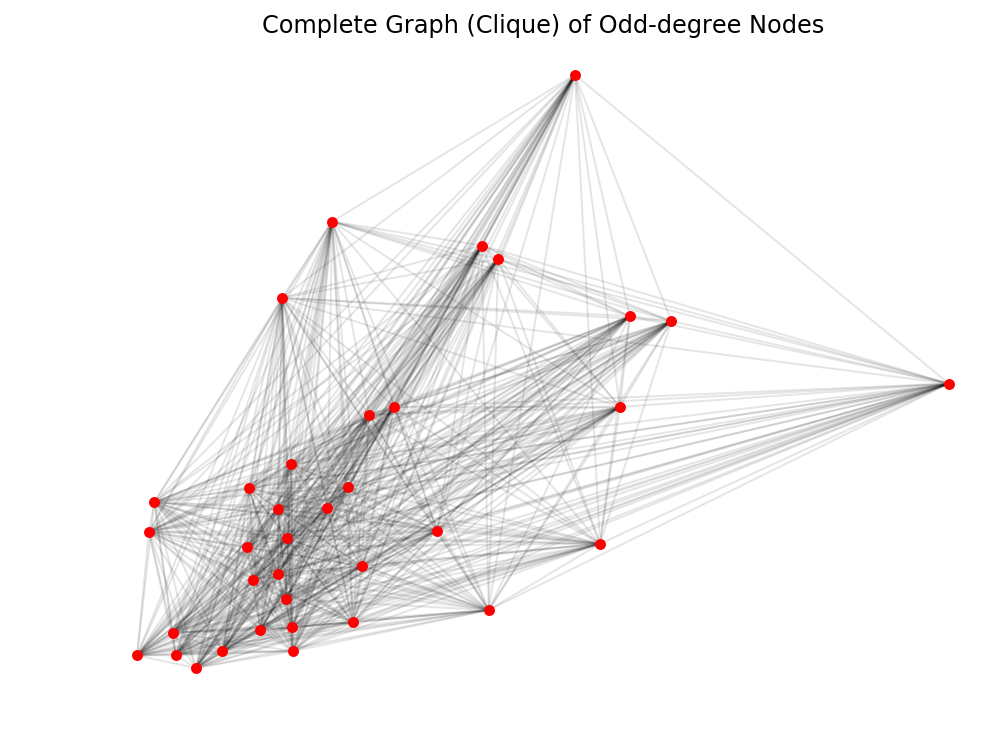

In [69]:
# Plot the clique graph of odd-degree nodes

plt.figure(figsize=(8,6))
pos_random = nx.random_layout(g_odd_clique)
nx.draw_networkx_nodes(g_odd_clique, node_positions, node_size=20, node_color='red')
nx.draw_networkx_edges(g_odd_clique, node_positions, alpha=0.1)

plt.axis('off')
plt.title('Complete Graph (Clique) of Odd-degree Nodes')
plt.show()

### Most complex step in CPP that finds odd-degree node-pairs whose distance-sum minimised
- autrement: selecting optimal 18-edge (36 odd-degree nodes / 2) from hariball of graph above
- Both implementation and intuition of this optimisation (MAXIMUM WEIGHT MATCHING) are beyond scope (see networkx source code for algorithms.matching 800+ lines) (based on Galil, Zvi (1986) of $O(n^3)$ time

> first breakthrough in 1965 proved that MM problem could be solved in polynomial time Jack Edmonds ["Paths, trees, and flowers"](https://cms.math.ca/openaccess/cjm/v17/cjm1965v17.0449-0467.pdf)


In [72]:
# (4) Compute Min Weight Matching of graph (3) - or find how to pair odd nodes that sum(distance) minimised)
# max_weight_matching uses 'weight' attr by default as the attr to max

odd_matching = nx.algorithms.max_weight_matching(g_odd_clique, True)

print(f'# edges in matching: {len(odd_matching)}')

odd_matching

# edges in matching: 18


{('b_bv', 'v_bv'),
 ('g_gy2', 'b_end_east'),
 ('o_rt', 'o_w_1'),
 ('o_tt', 'rh_end_tt_2'),
 ('o_y_tt_end_west', 'nature_end_west'),
 ('rc_end_north', 'g_gy1'),
 ('rd_end_north', 'rh_end_north'),
 ('rd_end_south', 'b_end_west'),
 ('rh_end_south', 'y_rh'),
 ('rh_end_tt_1', 'b_bw'),
 ('rh_end_tt_3', 'rh_end_tt_4'),
 ('rt_end_north', 'b_tt_3'),
 ('v_end_east', 'rs_end_north'),
 ('v_end_west', 'b_v'),
 ('w_bw', 'g_w'),
 ('y_gy1', 'rc_end_south'),
 ('y_gy2', 'rs_end_south'),
 ('y_rt', 'rt_end_south')}

<Figure size 576x432 with 0 Axes>

Text(0.5, 1.0, 'Min Weight Matching on Clique Graph')

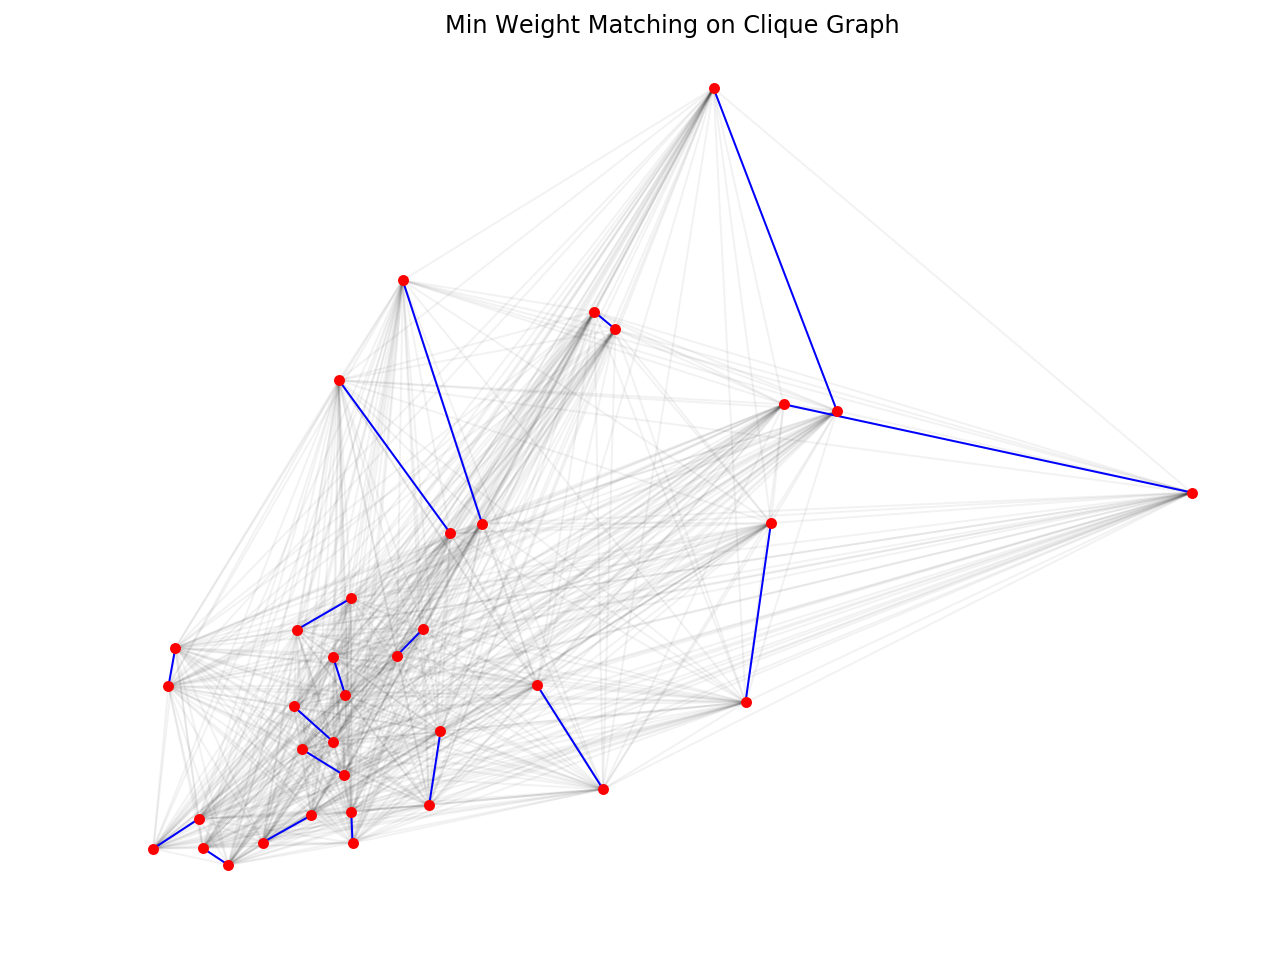

In [77]:
# Visualise this: while node positions reflect true graph (trail map), edge distances 
# shown are crow flies - actual SP could have multple edges twist and turn longer distance

plt.figure(figsize=(8,6))

# clique graph of odd-degree nodes
nx.draw(g_odd_clique, pos=node_positions, node_size=20, alpha=0.05)

# new graph overlays above with only MWM edges
g_odd_clique_min_edges = nx.Graph(list(odd_matching))
nx.draw(g_odd_clique_min_edges, pos=node_positions, node_size=20, edge_color='blue', node_color='red')

plt.title('Min Weight Matching on Clique Graph')
plt.show()

To illustrate how this fits in with the original graph, plot the same MW paris (blue) but over trail map (faded) instead of complete graph. Note blue lines are bushwahcking route (crow flies edges not actual trails). Still left is to find edges comprising SP between each pair in (3)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Text(0.5, 1.0, 'Min Weight Matching on Orginal Graph')

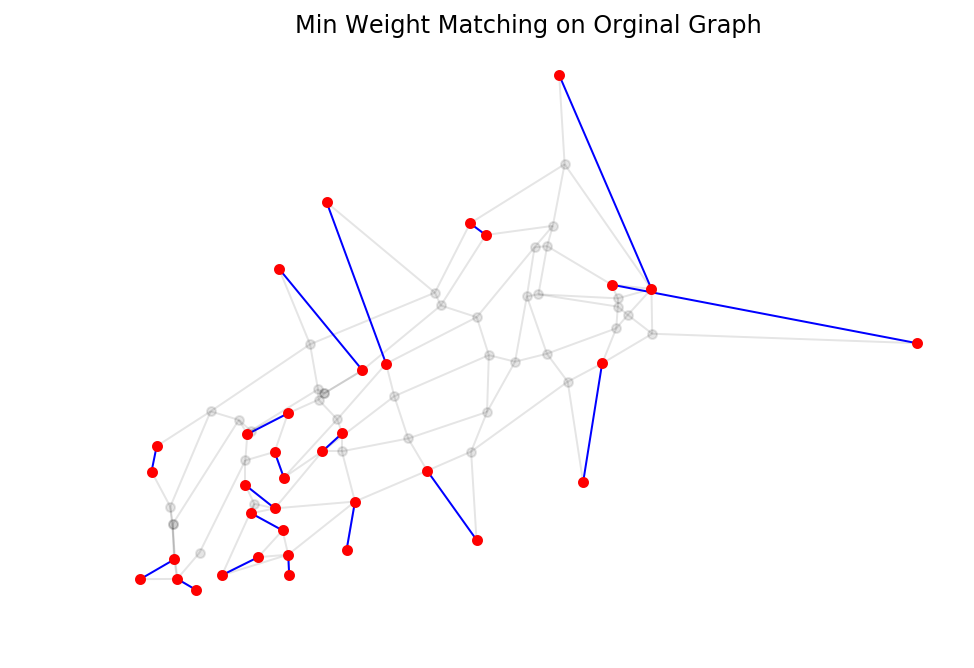

In [78]:
# Plot the original trail map graph
nx.draw(g, pos=node_positions, node_size=20, alpha=0.1, node_color='black')

# Plot graph to overlay with just the edges from the min weight matching
nx.draw(g_odd_clique_min_edges, pos=node_positions, node_size=20, alpha=1, node_color='red', edge_color='blue')

plt.title('Min Weight Matching on Orginal Graph')
plt.show()

In [79]:
# (5) Augment original graph with SP between node pairs in (4)

def add_augmenting_path_to_graph(graph, min_weight_pairs):
    """
    Add the min weight matching edges to the original graph
    Parameters:
        graph: NetworkX graph (original graph from trailmap)
        min_weight_pairs: list[tuples] of node pairs from min weight matching
    Returns:
        augmented NetworkX graph
    """

    # We need to make the augmented graph a MultiGraph so we can add parallel edges
    graph_aug = nx.MultiGraph(graph.copy())
    for pair in min_weight_pairs:
        graph_aug.add_edge(pair[0], 
                           pair[1], 
                           attr_dict={'distance': nx.dijkstra_path_length(graph, pair[0], pair[1]),
                                      'trail': 'augmented'}
                          )
    return graph_aug

In [81]:
# Create augmented graph: add the min weight matching edges to g
g_aug = add_augmenting_path_to_graph(g, odd_matching)

# Counts
print(f'Number of edges in original graph: {len(g.edges())}')
print(f'Number of edges in augmented graph: {len(g_aug.edges())}')


Number of edges in original graph: 123
Number of edges in augmented graph: 141


### Step 3: Compute Eulerian Circuit
Now that graph with even degree the hard optimisation work is done, as Euler famously postulated in 1736 with the Seven Bridges of Knoigsberg problem, there exists a path which visists each edge exactly once if all nodes have even degree.
- there're many Eulerian tours, 90% done with `eulerian_circuit` function, with limitations
    - aug-graph likely contains edges new to original graph, and must break down aug-edges into SP through edges actually exist
    - the func only returns order in which hitting each node, no the attr of edges needed to complete tour, for tracking which edges walked already when multiple edges exists

In [83]:
# Naive Circuit
naive_euler_circuit = list(nx.eulerian_circuit(g_aug, source='b_end_east'))

# As noted, length equals # edges in aug-graph
print(f'Length of eulerian circuit: {len(naive_euler_circuit)}')

Length of eulerian circuit: 141


In [84]:
# Preview naive Euler circuit
naive_euler_circuit[0:10]

[('b_end_east', 'g_gy2'),
 ('g_gy2', 'park_east'),
 ('park_east', 'b_y'),
 ('b_y', 'y_gy2'),
 ('y_gy2', 'rs_end_south'),
 ('rs_end_south', 'y_rs'),
 ('y_rs', 'y_gy2'),
 ('y_gy2', 'o_gy2'),
 ('o_gy2', 'b_o'),
 ('b_o', 'park_east')]

In [90]:
# Correct Circuit


# Now let's define a function that utilizes the original graph to tell you which trails to use to get from node A to node B. 
# Although verbose in code, this logic is actually quite simple. 
# You simply transform the naive circuit which included edges that did not exist in the original graph to a Eulerian circuit using only edges that exist in the original graph.
# 
# You loop through each edge in the naive Eulerian circuit (naive_euler_circuit). 
# Wherever you encounter an edge that does not exist in the original graph, you replace it with the sequence of edges comprising the shortest path between its nodes using the original graph.


def create_eulerian_circuit(graph_augmented, graph_original, starting_node=None):
    """Create the eulerian path using only edges from the original graph."""
    euler_circuit = []
    naive_circuit = list(nx.eulerian_circuit(graph_augmented, source=starting_node))

    for edge in naive_circuit:
        edge_data = graph_augmented.get_edge_data(edge[0], edge[1])    

        if edge_data[0]['trail'] != 'augmented':
            # If `edge` exists in original graph, grab the edge attributes and add to eulerian circuit.
            edge_att = graph_original[edge[0]][edge[1]]
            euler_circuit.append((edge[0], edge[1], edge_att)) 
        else: 
            aug_path = nx.shortest_path(graph_original, edge[0], edge[1], weight='distance')
            aug_path_pairs = list(zip(aug_path[:-1], aug_path[1:]))

            print(f'Filling in edges for augmented edge: {edge}')
            print(f'Augmenting path pairs: {aug_path_pairs}\n')

            # If `edge` does not exist in original graph, find the shortest path between its nodes and 
            #  add the edge attributes for each link in the shortest path.
            for edge_aug in aug_path_pairs:
                edge_aug_att = graph_original[edge_aug[0]][edge_aug[1]]
                euler_circuit.append((edge_aug[0], edge_aug[1], edge_aug_att))

    return euler_circuit

In [92]:
# Create the Eulerian circuit
euler_circuit = create_eulerian_circuit(g_aug, g, 'b_end_east')

KeyError: 'trail'

In [93]:
print('Length of Eulerian circuit: {}'.format(len(euler_circuit)))

NameError: name 'euler_circuit' is not defined

## [Continue...](https://www.datacamp.com/community/tutorials/networkx-python-graph-tutorial)